In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# 1. Data generation

## Simulating clean signal

Text(0, 0.5, 'y')

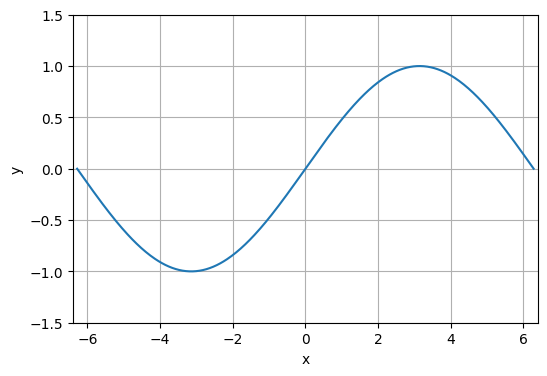

In [4]:
# we simulate a sin signal here
n = 400
x = np.linspace(-2*np.pi, 2*np.pi, n)
y = np.sin(x/2)
plt.figure(figsize=(6,4))
plt.plot(x, y)
plt.grid(True)
plt.axis([-6.4, 6.4, -1.5, 1.5])
plt.xlabel('x')
plt.ylabel('y')

## Add some noise (simulate uncertainty during observing the data)

Text(0, 0.5, 'y')

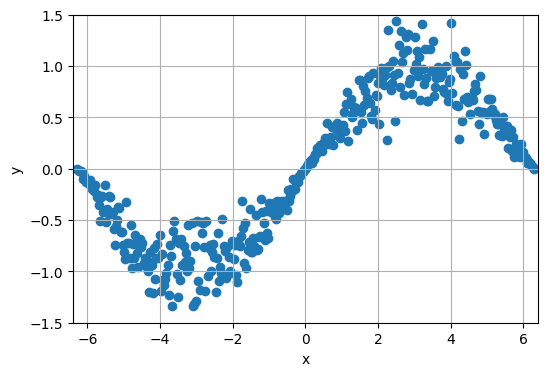

In [5]:
# set seed for reproducibility
np.random.seed(0)

# add noise, we let regions with higher abs(y) value to have larger noise
# to simulate some observations have more uncertainty than others
y_noisy = y + np.random.normal(0, scale = abs(y)/4)

plt.figure(figsize=(6,4))
plt.scatter(x, y_noisy)
plt.grid(True)
plt.axis([-6.4, 6.4, -1.5, 1.5])
plt.xlabel('x')
plt.ylabel('y')

# 2. Training NN without uncertainty estimation

## Setup neural network

In [6]:
# setup seed for reproducibility of initial model weights
torch.random.manual_seed(0)

# create a 3 layer MLP
model = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)
# setup optimizer, we use simple SGD here
opt = torch.optim.SGD(model.parameters(), 0.002, momentum=0.5)

## Training

 9999 - 0.029    

Text(0, 0.5, 'loss')

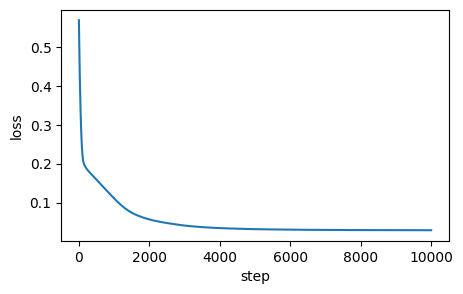

In [7]:
# prepare training inputs and outputs
x_in = torch.tensor(x).view(n, 1).float()
y_gt = torch.tensor(y_noisy).view(n, 1).float()

# start training for 10000 steps
num_steps = 10000
log = np.zeros(num_steps)
for i in range(num_steps):
    out = model(x_in)

    # MSE loss
    loss = ((out - y_gt) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    log[i] = loss
    opt.step()
    print(f'\r {i} - {loss.item():.3f}   ', end='\0')

# show learning curve
plt.figure(figsize=(5,3))
plt.plot(np.arange(num_steps), log)
plt.xlabel('step')
plt.ylabel('loss')

## Results

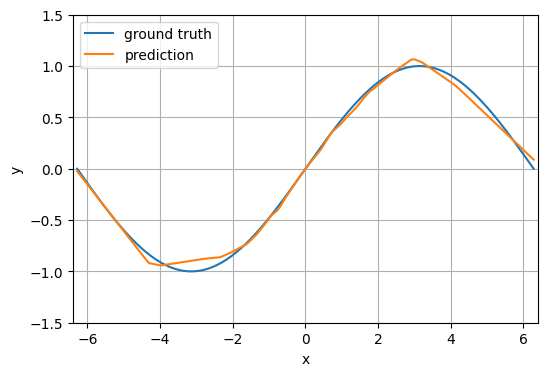

In [8]:
plt.figure(figsize=(6,4))
plt.grid(True)
plt.plot(x, y, label = 'ground truth')
plt.plot(x, out.detach().numpy(), label = 'prediction')
plt.axis([-6.4, 6.4, -1.5, 1.5])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# 3. Traininig with uncertainty estimation

## Setup neural network

In [9]:
# setup seed for reproducibility of initial model weights
torch.random.manual_seed(0)

# create a 3 layer MLP
model = nn.Sequential(
    nn.Linear(1, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2)  # set output channels to 2 (prediction and uncertainty)
)
# setup optimizer, we use simple SGD here
opt = torch.optim.SGD(model.parameters(), 0.002, momentum=0.5)

## Training

 9999 - -1.524    

Text(0, 0.5, 'loss')

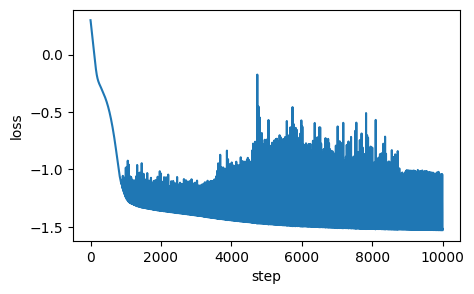

In [10]:
# prepare training inputs and outputs
x_in = torch.tensor(x).view(n, 1).float()
y_gt = torch.tensor(y_noisy).view(n, 1).float()

# start training for 10000 steps
num_steps = 10000
log = np.zeros(num_steps)
for i in range(num_steps):
    out = model(x_in)
    mu, log_sigma = out[:, :1], out[:, 1:]

    # MSE loss with uncertainty as learned loss attenuation
    loss = (((mu - y_gt) ** 2) / 2 * (-log_sigma).exp() + log_sigma / 2).mean()
    opt.zero_grad()
    loss.backward()
    log[i] = loss
    opt.step()
    print(f'\r {i} - {loss.item():.3f}   ', end='\0')

# show learning curve
plt.figure(figsize=(5,3))
plt.plot(np.arange(num_steps), log)
plt.xlabel('step')
plt.ylabel('loss')

## Results

Text(0, 0.5, '(log) sigma')

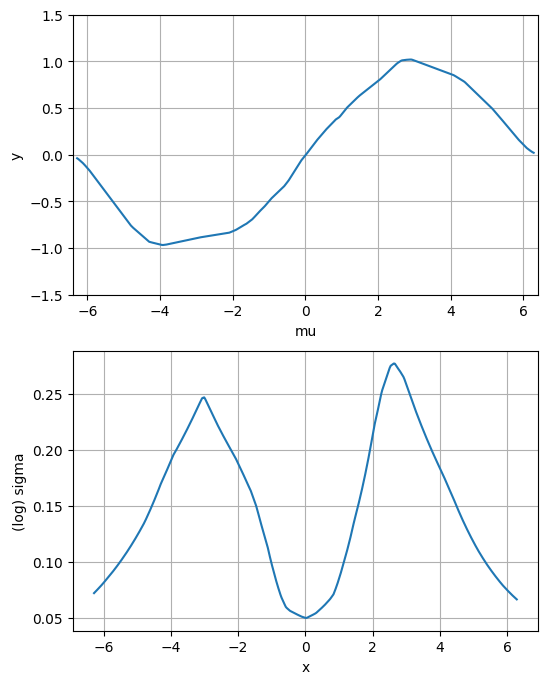

In [11]:
plt.figure(figsize=(6,8))
plt.subplot(2,1,1)
plt.grid(True)
plt.plot(x, mu.detach().numpy())
plt.axis([-6.4, 6.4, -1.5, 1.5])
plt.xlabel('mu')
plt.ylabel('y')

plt.subplot(2,1,2)
plt.grid(True)
plt.plot(x, log_sigma.detach().exp().numpy()**0.5)
plt.xlabel('x')
plt.ylabel('(log) sigma')

## Put inputs, predictions and estimated uncertainty together

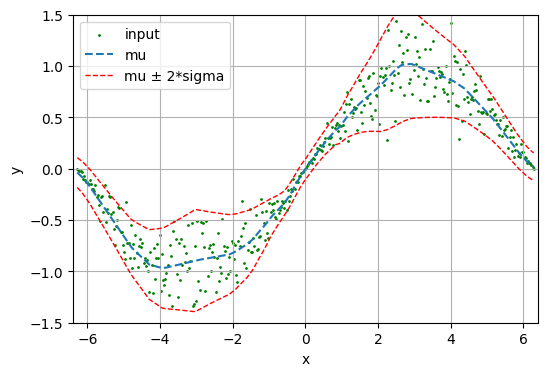

In [12]:
# log sigma to sigma
s = log_sigma.detach().exp().numpy()**0.5
m = mu.detach().numpy()
plt.figure(figsize=(6,4))
plt.scatter(x, y_noisy, s=1, c='g', label='input')
plt.grid(True)
plt.axis([-6.4, 6.4, -1.5, 1.5])
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, m, '--', label = 'mu')
plt.plot(x, m-s*2, '--', c='r', lw=1)
plt.plot(x, m+s*2, '--', c='r', lw=1, label = 'mu ± 2*sigma')
plt.legend()